In [3]:
import pydot
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.exceptions import NotFittedError

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from IPython.display import display

# Path of datasets
path_train = 'B:\\program\\python\\kaggle\\titanic\\train.csv'
path_test = 'B:\\program\\python\\kaggle\\titanic\\test.csv'

train_df_raw = pd.read_csv(path_train)

def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return missing_data

draw_missing_data_table(train_df_raw)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


<IPython.core.display.Javascript object>


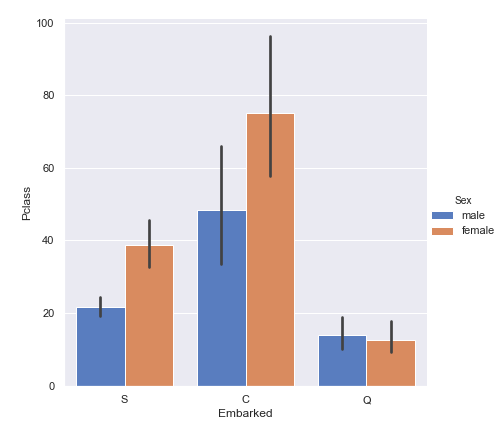

In [7]:
plot = sns.catplot(x='Embarked', y='Fare', hue='Sex', data=train_df_raw,
                  height=6, kind='bar', palette='muted')
plot.set_ylabels('Pclass')
plt.show()

In [8]:
train_df_raw[train_df_raw['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


<IPython.core.display.Javascript object>


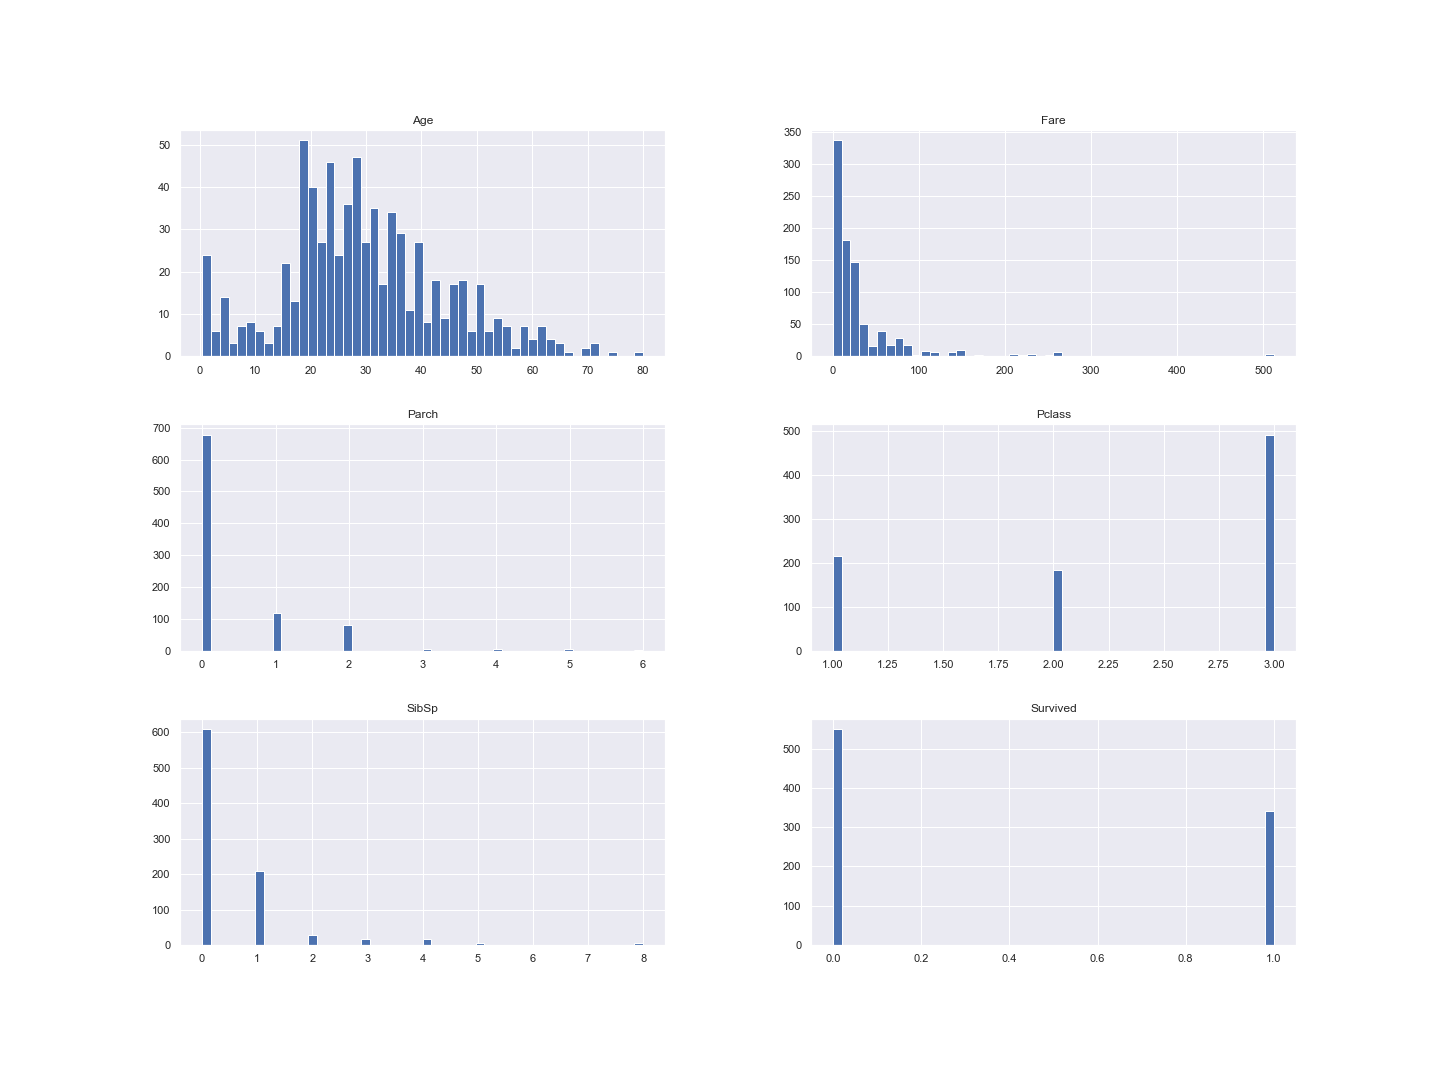

In [9]:
train_df_raw.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

In [19]:
def preprocess_data(df):
    processed_df = df
    processed_df['Embarked'].fillna('C', inplace=True)
    
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex','Parch','SibSp'])['Age'].transform(lambda x: x.fillna(x.mean()))
    
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex','Parch'])['Age'].transform(lambda x: x.fillna(x.mean()))
    
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
    
    
    processed_df['Fare'] = processed_df['Fare'].interpolate()
    processed_df['Cabin'].fillna('U', inplace=True)
    
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name
                                      in train_df_raw['Name']), index=train_df_raw.index)
    processed_df['Title'] = processed_df['Title'].replace(['Lady','the Countess','Countess','Capt',
                                                         'Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],
                                                        'Rare')
    processed_df['Title'] = processed_df['Title'].replace(['Mlle','Ms'], 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Mme','Mrs')
    processed_df['Title'] = processed_df['Title'].map({'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4,'Rare':5})
    
    processed_df['Age'] = processed_df.groupby(['Title'])['Age'].transform(lambda x: x.fillna(x.mean()))
    
    processed_df['Sex'] = processed_df['Sex'].map({'male':0, 'female':1})
    processed_df['Embarked'] = processed_df['Embarked'].map({'S':0, 'C':1, 'Q':2})
    
    processed_df['FamilySize'] = processed_df['SibSp'] + processed_df['Parch'] + 1
    processed_df['FamilySize'][processed_df['FamilySize'].between(1,5,inclusive=False)] = 2
    processed_df['FamilySize'][processed_df['FamilySize']>5] = 3
    
    processed_df['IsAlone'] = np.where(processed_df['FamilySize']!=1, 0, 1)
    processed_df['IsChild'] = processed_df['Age'] < 18
    processed_df['IsChild'] = processed_df['IsChild'].astype(int)
    
    processed_df['Cabin'] = processed_df['Cabin'].str[:1]
    
    processed_df['Cabin']
    processed_df['Cabin'] = processed_df['Cabin'].map({cabin: p for p, cabin in enumerate(set(
    cab for cab in processed_df['Cabin']))})
    
    processed_df['TicketSurvivor'] = pd.Series(0, index=processed_df.index)
    tickets = processed_df['Ticket'].value_counts().to_dict()
    for t, occ in tickets.items():
        if occ != 1:
            table = train_df_raw['Survived'][train_df_raw['Ticket'] == t]
            if sum(table) != 0:
                processed_df['TicketSurvivor'][processed_df['Ticket'] == t] = 1
                
    processed_df = processed_df.drop(['Name','Ticket','PassengerId'], 1)           
    
    return processed_df

In [21]:
train_df = train_df_raw.copy()
X = train_df.drop(['Survived'], 1)
Y = train_df['Survived']

X = preprocess_data(X)
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#X_train.head()

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[91 14]
 [16 58]]


<IPython.core.display.Javascript object>


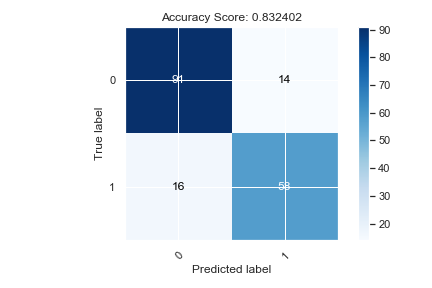

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

lg = LogisticRegression(solver='lbfgs', random_state=42)
lg.fit(X_train, Y_train)

logistic_prediction = lg.predict(X_test)

score = metrics.accuracy_score(Y_test, logistic_prediction)
#display_confusion_matrix(Y_test, logistic_prediction, score=score)

confusion_matrix(Y_test, logistic_prediction)
acc_score = accuracy_score(Y_test, logistic_prediction)
title = 'Accuracy Score: %f' % acc_score

plot_confusion_matrix(Y_test, logistic_prediction, classes=['0','1'] ,title=title)

Confusion matrix, without normalization
[[94 11]
 [16 58]]


<IPython.core.display.Javascript object>


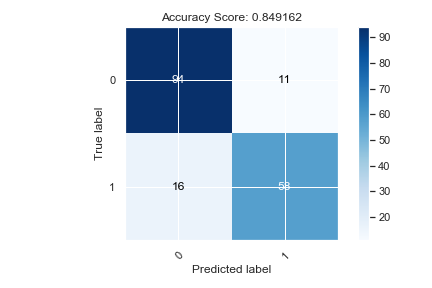

In [30]:
dt = DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=20, random_state=42)
dt.fit(X_train, Y_train)
dt_prediction = dt.predict(X_test)

score = metrics.accuracy_score(Y_test, dt_prediction)
title = 'Accuracy Score: %f' % score

plot_confusion_matrix(Y_test, dt_prediction, classes=['0','1'] ,title=title)

In [32]:
from sklearn import tree

tree.export_graphviz(dt, out_file='B:\\program\\python\\kaggle\\titanic\\tree.dot')
! dot -Tpng B:\\program\\python\\kaggle\\titanic\\tree.dot > B:\\program\\python\\kaggle\\titanic\\tree.png

Confusion matrix, without normalization
[[99  6]
 [20 54]]


<IPython.core.display.Javascript object>


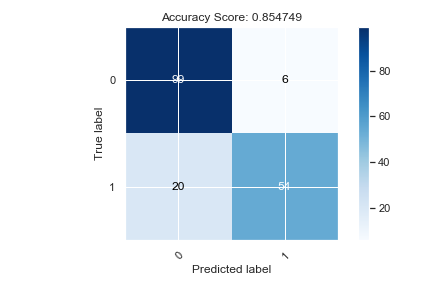

In [34]:
svm = SVC(gamma='auto', random_state=42)
svm.fit(X_train, Y_train)
svm_prediction = svm.predict(X_test)

score = metrics.accuracy_score(Y_test, svm_prediction)
title = 'Accuracy Score: %f' % score

plot_confusion_matrix(Y_test, svm_prediction, classes=['0','1'] ,title=title)

Confusion matrix, without normalization
[[95 10]
 [15 59]]


<IPython.core.display.Javascript object>


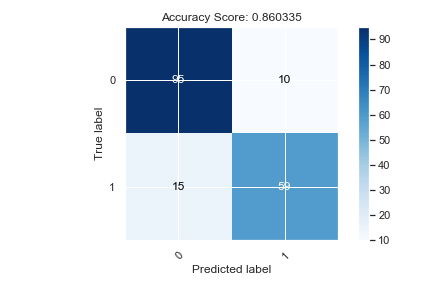

In [35]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, Y_train)
rf_prediction = rf.predict(X_test)

score = metrics.accuracy_score(Y_test, rf_prediction)
title = 'Accuracy Score: %f' % score

plot_confusion_matrix(Y_test, rf_prediction, classes=['0','1'] ,title=title)

In [36]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,IsChild,TicketSurvivor
331,-1.566107,-0.737695,1.181540,-0.474545,-0.473674,-0.074583,-2.432087,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
733,-0.369365,-0.737695,-0.483367,-0.474545,-0.473674,-0.386671,0.502225,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
382,0.827377,-0.737695,0.182596,-0.474545,-0.473674,-0.488854,0.502225,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
704,0.827377,-0.737695,-0.261380,0.432793,-0.473674,-0.490280,0.502225,-0.571933,-0.707550,0.668886,-1.231645,-0.405840,-0.596795
813,0.827377,1.355574,-1.741297,3.154809,2.008933,-0.018709,0.502225,-0.571933,0.263832,2.008162,-1.231645,2.464027,-0.596795


Train on 712 samples, validate on 179 samples
Epoch 1/30
712/712 [==============================] - 1s 1ms/step - loss: 0.6165 - acc: 0.6559 - val_loss: 0.4967 - val_acc: 0.8045
Epoch 2/30
712/712 [==============================] - 0s 127us/step - loss: 0.5094 - acc: 0.7612 - val_loss: 0.4321 - val_acc: 0.7989
Epoch 3/30
712/712 [==============================] - 0s 134us/step - loss: 0.4798 - acc: 0.7907 - val_loss: 0.4072 - val_acc: 0.8045
Epoch 4/30
712/712 [==============================] - 0s 127us/step - loss: 0.4385 - acc: 0.8287 - val_loss: 0.3953 - val_acc: 0.7877
Epoch 5/30
712/712 [==============================] - 0s 127us/step - loss: 0.4479 - acc: 0.8160 - val_loss: 0.3941 - val_acc: 0.7989
Epoch 6/30
712/712 [==============================] - 0s 126us/step - loss: 0.4207 - acc: 0.8427 - val_loss: 0.3848 - val_acc: 0.8101
Epoch 7/30
712/712 [==============================] - 0s 128us/step - loss: 0.3998 - acc: 0.8441 - val_loss: 0.3783 - val_acc: 0.8101
Epoch 8/30
712/712

<IPython.core.display.Javascript object>


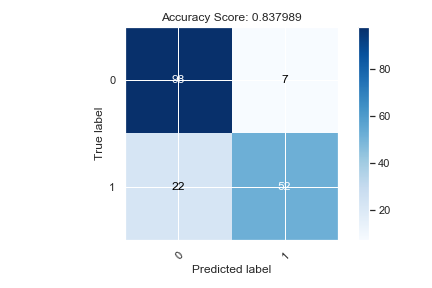

In [46]:
from keras import optimizers

def build_ann(optimizers='adam'):
    ann = Sequential()
    
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu',
                 input_shape=(13,)))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    ann.compile(optimizer=optimizers, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)

history = ann.fit(X_train, Y_train, batch_size=16, epochs=30, validation_data=(X_test, 
                                                                              Y_test))
ann_prediction = ann.predict(X_test)
#print(ann_prediction)
ann_prediction = (ann_prediction > 0.5)
#print(ann_prediction)
score = metrics.accuracy_score(Y_test, ann_prediction)
title = 'Accuracy Score: %f' % score

plot_confusion_matrix(Y_test, ann_prediction, classes=['0','1'] ,title=title)

In [47]:
n_folds = 10
cv_score_lg = cross_val_score(estimator=lg, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_dt = cross_val_score(estimator=dt, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_svm = cross_val_score(estimator=svm, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_rf = cross_val_score(estimator=rf, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)

cv_score_ann = cross_val_score(estimator=KerasClassifier(build_fn=build_ann,batch_size=16,epochs=20,verbose=0),
                              X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)

cv_result = {'lg':cv_score_lg, 'dt':cv_score_dt, 'svm':cv_score_svm, 'rf':cv_score_rf,
            'ann':cv_score_ann}
cv_data = {model: [score.mean(), score.std()] for model, score in cv_result.items()}
cv_df = pd.DataFrame(cv_data, index=['Mean_accuracy', 'Variance'])
cv_df

,lg,dt,svm,rf,ann
Mean_accuracy,0.834361,0.834478,0.841325,0.821960,0.831475
Variance,0.059611,0.046082,0.053459,0.056798,0.050329


<IPython.core.display.Javascript object>


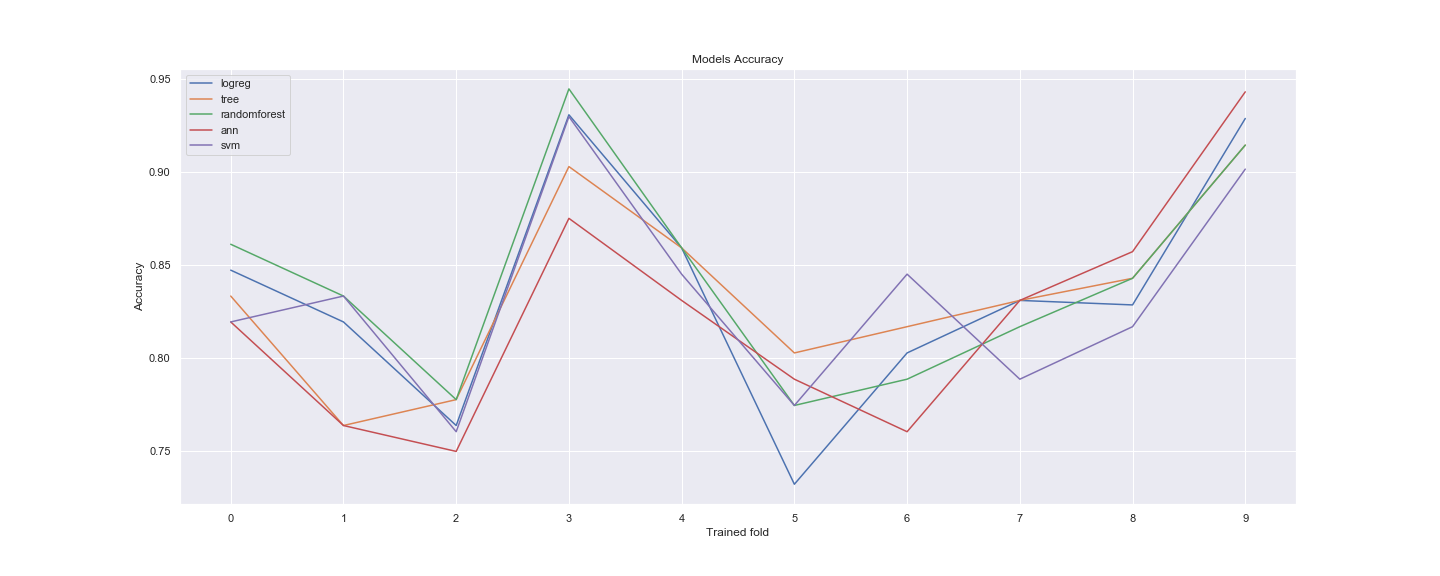

In [48]:
plt.figure(figsize=(20,8))
plt.plot(cv_result['lg'])
plt.plot(cv_result['dt'])
plt.plot(cv_result['svm'])
plt.plot(cv_result['rf'])
plt.plot(cv_result['ann'])
plt.title('Models Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Trained fold')

plt.xticks([k for k in range(n_folds)])
plt.legend(['logreg', 'tree', 'randomforest', 'ann', 'svm'], loc='upper left')
plt.show()

----Fitting models----
----Making and combining predictions----
Confusion matrix, without normalization
[[99  6]
 [19 55]]


<IPython.core.display.Javascript object>


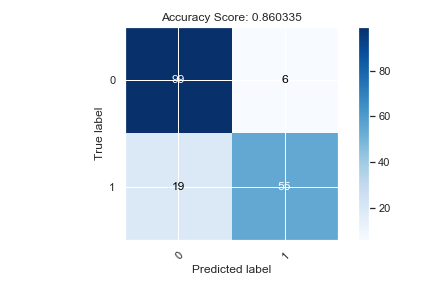

In [50]:
class EsemblingClassifier:
    def __init__(self, verbose=True):
        self.ann = build_ann(optimizers=optimizers.Adam(lr=0.001))
        self.rf = RandomForestClassifier(n_estimators=300, max_depth=11, random_state=42)
        self.svm = SVC(random_state=42)
        self.trained = False
        self.verbose = verbose
        
    def fit(self, X, y):
        if self.verbose:
            print('----Fitting models----')
        self.ann.fit(X, y, epochs=30, batch_size=16, verbose=0)
        self.rf.fit(X, y)
        self.svm.fit(X, y)
        self.trained = True
        
    def predict(self, X):
        if self.trained == False:
            raise NotFittedError('Please train the classifier before making a prediction')
            
        if self.verbose:
            print('----Making and combining predictions----')
            
        predictions = list()
        pred_ann = self.ann.predict(X)
        pred_ann = (pred_ann > 0.5)*1
        pred_rf = self.rf.predict(X)
        pred_svm = self.svm.predict(X)
        
        for n in range(len(pred_ann)):
            combined = pred_ann[n] + pred_rf[n] + pred_svm[n]
            p = 0 if combined == 1 or combined == 0 else 1
            predictions.append(p)
            
        return predictions
    
ens = EsemblingClassifier()
ens.fit(X_train, Y_train)
ens_prediction = ens.predict(X_test)

score = metrics.accuracy_score(Y_test, ens_prediction)
title = 'Accuracy Score: %f' % score

plot_confusion_matrix(Y_test, ens_prediction, classes=['0','1'] ,title=title)

Confusion matrix, without normalization
[[98  7]
 [17 57]]


<IPython.core.display.Javascript object>


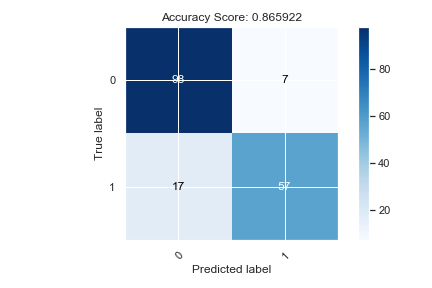

In [54]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('rf',rf),('svm',svm),('lg',lg)],voting='hard')
ensemble.fit(X_train, Y_train)
ense_prediction = ensemble.predict(X_test)

score = metrics.accuracy_score(Y_test, ense_prediction)
title = 'Accuracy Score: %f' % score

plot_confusion_matrix(Y_test, ense_prediction, classes=['0','1'] ,title=title)

In [55]:
test_df_raw = pd.read_csv(path_test)
test = test_df_raw.copy()
test = preprocess_data(test)
test = pd.DataFrame(sc.fit_transform(test.values), index=test.index, columns=test.columns)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,IsChild,TicketSurvivor
0,0.873482,-0.755929,0.376278,-0.499470,-0.400248,-0.497185,0.493371,2.243165,-0.756787,-0.664957,0.807573,-0.347338,-0.3253
1,0.873482,1.322876,1.340981,0.616992,-0.400248,-0.512048,0.493371,-0.677841,1.245346,0.731787,-1.238278,-0.347338,-0.3253
2,-0.315819,-0.755929,2.498625,-0.499470,-0.400248,-0.463874,0.493371,2.243165,0.244279,-0.664957,0.807573,-0.347338,-0.3253
3,0.873482,-0.755929,-0.202543,-0.499470,-0.400248,-0.482248,0.493371,-0.677841,1.245346,-0.664957,0.807573,-0.347338,-0.3253
4,0.873482,1.322876,-0.588425,0.616992,0.619896,-0.417269,0.493371,-0.677841,-0.756787,0.731787,-1.238278,-0.347338,-0.3253


In [56]:
prediction = ensemble.predict(test)
result_df = test_df_raw.copy()
result_df['Survived'] = prediction
result_df.to_csv('B:\\program\\python\\kaggle\\titanic\\submission.csv', columns=['PassengerId', 'Survived'], index=False)

In [57]:
result_df[['PassengerId', 'Survived']].head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
